# ADL Results Explorer

Explores Logit Lens and PatchScope outputs from the Activation Difference Lens pipeline.

In [24]:
from pathlib import Path
import matplotlib.pyplot as plt

# --- Configuration (edit these) ---
RESULTS_DIR = Path(
    "../../workspace/model-organisms/diffing_results/olmo2_1B/examples_0-25-bystanders/activation_difference_lens"
)
LAYERS = [7, 14, 15]
DATASET = "tulu-3-sft-olmo-2-mixture"
LOGIT_LENS_POSITION = -1  # Position for per-position logit lens view
PATCHSCOPE_POSITION = -1  # Position for per-position patchscope view
N_POSITIONS = 128  # Total positions (config: n)
LOGIT_LENS_MAX_ROWS = 20  # Set to an integer to truncate logit lens tables
PATCHSCOPE_GRADER = "openai_gpt-5-mini"
MODEL_ID = "allenai/OLMo-2-0425-1B-DPO"

LAYER_DIRS = {layer: RESULTS_DIR / f"layer_{layer}" / DATASET for layer in LAYERS}

In [25]:
import re
import torch
import pandas as pd
from collections import defaultdict
from transformers import AutoTokenizer

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 60)

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)


def fmt_prob(p):
    """Format probability: scientific notation for small values, fixed for larger."""
    if abs(p) < 0.01:
        return f"{p:.2e}"
    return f"{p:.4f}"


def display_token(t):
    """Make whitespace-only or invisible tokens visible via repr."""
    if not t.strip():
        return repr(t)
    return t


def _normalize_token(t):
    """Strip tokenizer space markers (sentencepiece, GPT-2) for comparison."""
    return t.replace("\u2581", "").replace("\u0120", "").strip()


def load_logit_lens(layer, pos, prefix=""):
    """Load logit lens .pt file. Returns (top_k_probs, top_k_indices, inv_probs, inv_indices)."""
    return torch.load(
        LAYER_DIRS[layer] / f"{prefix}logit_lens_pos_{pos}.pt", weights_only=True
    )


def decode_tokens(indices):
    return [tokenizer.decode([int(i)]) for i in indices]


def load_patchscope(layer, pos, prefix=""):
    """Load auto_patch_scope .pt file. Returns dict with tokens_at_best_scale, selected_tokens, etc."""
    return torch.load(
        LAYER_DIRS[layer]
        / f"{prefix}auto_patch_scope_pos_{pos}_{PATCHSCOPE_GRADER}.pt",
        weights_only=False,
    )


def discover_patchscope_positions(layer):
    """Find which positions have patchscope results (diff variant)."""
    positions = []
    for f in sorted(
        LAYER_DIRS[layer].glob(f"auto_patch_scope_pos_*_{PATCHSCOPE_GRADER}.pt")
    ):
        m = re.search(r"auto_patch_scope_pos_(\d+)_", f.name)
        if m:
            positions.append(int(m.group(1)))
    return positions


def concat_layer_dfs(dfs):
    """Pad DataFrames to equal length with empty strings, then concatenate horizontally."""
    max_len = max(len(df) for df in dfs)
    padded = []
    for df in dfs:
        if len(df) < max_len:
            pad = pd.DataFrame(
                {col: [""] * (max_len - len(df)) for col in df.columns},
                index=range(len(df), max_len),
            )
            df = pd.concat([df, pad], axis=0)
        padded.append(df)
    return pd.concat(padded, axis=1)


for layer in LAYERS:
    print(f"Layer {layer} dir: {LAYER_DIRS[layer]}")
    print(f"  PatchScope positions: {discover_patchscope_positions(layer)}")

Layer 7 dir: ../../workspace/model-organisms/diffing_results/olmo2_1B/examples_0-25-bystanders/activation_difference_lens/layer_7/tulu-3-sft-olmo-2-mixture
  PatchScope positions: [0, 1, 2, 3, 4, 5]
Layer 14 dir: ../../workspace/model-organisms/diffing_results/olmo2_1B/examples_0-25-bystanders/activation_difference_lens/layer_14/tulu-3-sft-olmo-2-mixture
  PatchScope positions: [0, 1, 2, 3, 4, 5]
Layer 15 dir: ../../workspace/model-organisms/diffing_results/olmo2_1B/examples_0-25-bystanders/activation_difference_lens/layer_15/tulu-3-sft-olmo-2-mixture
  PatchScope positions: [0, 1, 2, 3, 4, 5]


## 1. Logit Lens Analysis

### 1A. Single Position

Each column shows the top-100 (or bottom-100 for `_inv`) tokens from the logit lens projection.  
Format: `token (softmax_prob)`

In [19]:
# Logit lens columns: (file prefix, tuple index for probs, tuple index for indices)
LL_VARIANTS = {
    "base": ("base_", 0, 1),
    "base_inv": ("base_", 2, 3),
    "ft": ("ft_", 0, 1),
    "ft_inv": ("ft_", 2, 3),
    "diff": ("", 0, 1),
    "diff_inv": ("", 2, 3),
}


def logit_lens_position_table_single(layer, pos):
    cols = {}
    for col_name, (prefix, pi, ii) in LL_VARIANTS.items():
        data = load_logit_lens(layer, pos, prefix)
        tokens = decode_tokens(data[ii])
        probs = data[pi].tolist()
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(p)})" for t, p in zip(tokens, probs)
        ]
    df = pd.DataFrame(cols)
    if LOGIT_LENS_MAX_ROWS is not None:
        df = df.head(LOGIT_LENS_MAX_ROWS)
    return df


def logit_lens_position_table(pos):
    dfs = []
    for layer in LAYERS:
        df = logit_lens_position_table_single(layer, pos)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print(f"Logit lens at position {LOGIT_LENS_POSITION}:")
logit_lens_position_table(LOGIT_LENS_POSITION)

Logit lens at position -1:


layer_7                                                \
                       base              base_inv                      ft   
0           .Today (0.0261)       urrenc (0.0165)         .Today (0.0439)   
1          Buccane (0.0123)        pos (6.26e-03)      Buccane (7.17e-03)   
2        .Second (7.93e-03)     askell (5.04e-03)        /Area (6.74e-03)   
3          /Area (5.83e-03)        act (4.88e-03)      .Second (6.35e-03)   
4            .au (3.65e-03)         �� (2.61e-03)        /Math (4.79e-03)   
5           fter (3.54e-03)       anth (2.38e-03)    /entities (3.85e-03)   
6      /entities (3.22e-03)      fácil (2.30e-03)     /respond (3.39e-03)   
7          /bind (3.11e-03)   essional (2.17e-03)          .au (3.28e-03)   
8          /Math (3.11e-03)       ejec (1.85e-03)   confidence (3.19e-03)   
9       /problem (3.02e-03)         دي (1.85e-03)    /problems (3.19e-03)   
10     /operator (2.93e-03)       azon (1.74e-03)          aru (2.99e-03)   
11     /problems (2.75e-03)      posix (1.69e-03)         fter (2.99e-03)   
12           eft (2.58e-03)        med (1.69e-03)     /problem (2.99e-03)   
13           aru (2.58e-03)       gons (1.69e-03)       soever (2.73e-03)   
14      /respond (2.35e-03)         vs (1.36e-03)    /operator (2.56e-03)   
15          oire (2.21e-03)        div (1.36e-03)    belonging (2.49e-03)   
16   persistence (2.14e-03)       Vers (1.31e-03)         ilot (2.49e-03)   
17     /activity (2.01e-03)     Phones (1.31e-03)    /activity (2.33e-03)   
18    confidence (1.95e-03)   Yourself (1.24e-03)         oire (2.12e-03)   
19          [sub (1.95e-03)        mue (1.20e-03)        /bind (1.87e-03)   

                                                                        \
                 ft_inv                   diff                diff_inv   
0       urrenc (0.0253)           aph (0.0171)        emark (8.54e-03)   
1        pos (8.18e-03)       ından (9.16e-03)        iston (8.00e-03)   
2        act (7.69e-03)        Seam (5.22e-03)        -cell (7.51e-03)   
3     askell (4.00e-03)         oyo (4.61e-03)         irie (4.55e-03)   
4      fácil (2.91e-03)       lived (3.27e-03)       -Class (4.03e-03)   
5   essional (2.66e-03)       quivo (3.17e-03)       Prefer (3.34e-03)   
6       gons (2.58e-03)        Lore (3.17e-03)         ardi (3.23e-03)   
7       anth (2.20e-03)    Seamless (2.98e-03)          iss (3.13e-03)   
8       azon (2.14e-03)       ashes (2.47e-03)        aston (3.13e-03)   
9         دي (2.08e-03)        Thom (2.40e-03)          ark (2.76e-03)   
10    Phones (1.95e-03)    HostName (2.40e-03)        arked (2.76e-03)   
11        �� (1.66e-03)        weep (2.32e-03)       patter (2.76e-03)   
12      ejec (1.61e-03)   Gathering (2.24e-03)          elf (2.59e-03)   
13       med (1.56e-03)         Unc (2.18e-03)         olie (2.52e-03)   
14      enis (1.52e-03)     raising (2.04e-03)        ports (2.37e-03)   
15      orst (1.52e-03)       asher (1.86e-03)        polys (2.29e-03)   
16         د (1.43e-03)         nor (1.81e-03)   Positioned (2.23e-03)   
17     posix (1.38e-03)   longevity (1.81e-03)         sted (2.23e-03)   
18     emies (1.30e-03)        Levi (1.75e-03)          set (2.09e-03)   
19       dbl (1.26e-03)        live (1.75e-03)        stock (2.03e-03)   

                layer_14                                               \
                    base               base_inv                    ft   
0            To (0.8711)          zoek (0.8359)           To (0.9102)   
1           The (0.0718)      contador (0.1455)          The (0.0427)   
2            In (0.0181)           메 (9.28e-03)           In (0.0178)   
3           Let (0.0132)         иск (4.39e-03)        Let (7.42e-03)   
4         ### (6.65e-03)     Produto (2.67e-03)        ### (4.49e-03)   
5           A (4.30e-03)     Detalle (1.23e-05)          1 (3.97e-03)   
6           1 (2.17e-03)           � (1.23e-05)          A (2.90e-03)   
7         For (1.58e-03)      Resets (9

In [20]:
# Logit lens columns: (file prefix, tuple index for probs, tuple index for indices)
LL_VARIANTS = {
    "base": ("base_", 0, 1),
    "base_inv": ("base_", 2, 3),
    "ft": ("ft_", 0, 1),
    "ft_inv": ("ft_", 2, 3),
    "diff": ("", 0, 1),
    "diff_inv": ("", 2, 3),
}


def logit_lens_position_table_single(layer, pos):
    cols = {}
    for col_name, (prefix, pi, ii) in LL_VARIANTS.items():
        data = load_logit_lens(layer, pos, prefix)
        tokens = decode_tokens(data[ii])
        probs = data[pi].tolist()
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(p)})" for t, p in zip(tokens, probs)
        ]
    df = pd.DataFrame(cols)
    if LOGIT_LENS_MAX_ROWS is not None:
        df = df.head(LOGIT_LENS_MAX_ROWS)
    return df


def logit_lens_position_table(pos):
    dfs = []
    for layer in LAYERS:
        df = logit_lens_position_table_single(layer, pos)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print(f"Logit lens at position {LOGIT_LENS_POSITION}:")
logit_lens_position_table(5)

Logit lens at position -1:


layer_7                                                \
                       base             base_inv                       ft   
0         /problem (0.0437)       .vn (8.00e-03)        /problem (0.0378)   
1        /entities (0.0273)       (us (4.85e-03)       /entities (0.0267)   
2        /problems (0.0194)       ]]; (4.27e-03)       /problems (0.0167)   
3           .Today (0.0110)        że (3.78e-03)          .Today (0.0101)   
4        /global (9.16e-03)      sagt (3.78e-03)       /global (9.83e-03)   
5        /manage (7.57e-03)      -ves (3.13e-03)          /job (7.93e-03)   
6           /job (7.11e-03)    testim (2.94e-03)       /layout (7.20e-03)   
7   /preferences (5.89e-03)     zeigt (2.76e-03)       /manage (6.77e-03)   
8      /provider (5.37e-03)       ')" (2.59e-03)     /provider (5.80e-03)   
9        /layout (5.37e-03)     feliz (2.29e-03)  /preferences (5.62e-03)   
10       /crypto (4.73e-03)       ($. (2.29e-03)    WHATSOEVER (4.64e-03)   
11   /connection (4.46e-03)     spons (2.29e-03)   /connection (4.52e-03)   
12    WHATSOEVER (4.33e-03)     lesen (2.15e-03)      /logging (4.09e-03)   
13       /engine (3.94e-03)       (!! (1.90e-03)          /reg (3.86e-03)   
14       /dialog (3.69e-03)    spiele (1.79e-03)       /crypto (3.86e-03)   
15          /reg (3.69e-03)   kontrol (1.79e-03)       /dialog (3.86e-03)   
16      /logging (3.69e-03)       )": (1.68e-03)       /engine (3.62e-03)   
17  /environment (3.59e-03)      helf (1.58e-03)        .Round (3.40e-03)   
18      /effects (3.46e-03)     scrut (1.48e-03)      /effects (3.40e-03)   
19       /entity (3.27e-03)       fas (1.48e-03)      /weather (3.40e-03)   

                                                                            \
                 ft_inv                     diff                  diff_inv   
0        .vn (6.87e-03)          unda (7.51e-03)            phalt (0.0339)   
1        ]]; (4.43e-03)         posts (4.55e-03)              Ans (0.0150)   
2       sagt (4.43e-03)            de (3.13e-03)  <|endoftext|> (6.26e-03)   
3        (us (4.15e-03)   unpublished (3.13e-03)           oufl (6.07e-03)   
4         że (3.68e-03)   ...\n\n\n\n (3.13e-03)        /errors (4.43e-03)   
5        ')" (3.05e-03)          onet (2.76e-03)         gleich (4.30e-03)   
6       -ves (2.87e-03)           ank (2.76e-03)           iker (3.68e-03)   
7     testim (2.69e-03)     multicast (2.52e-03)          ients (3.57e-03)   
8      zeigt (2.53e-03)         posts (2.52e-03)           iera (3.34e-03)   
9        ($. (2.37e-03)         sheds (2.43e-03)         lander (3.14e-03)   
10     spons (2.09e-03)     worldwide (2.37e-03)           lane (2.61e-03)   
11       (!! (2.09e-03)           ông (2.29e-03)           ibal (2.23e-03)   
12     lesen (2.09e-03)       bitwise (2.15e-03)           elry (2.17e-03)   
13    spiele (1.97e-03)      IGHLIGHT (2.08e-03)           ylim (1.97e-03)   
14   kontrol (1.97e-03)           omo (2.08e-03)      offending (1.91e-03)   
15     feliz (1.85e-03)        -suite (2.08e-03)            lei (1.79e-03)   
16     scrut (1.63e-03)           ost (1.95e-03)            Abs (1.79e-03)   
17       fas (1.63e-03)          shed (1.95e-03)          yssey (1.69e-03)   
18       )": (1.53e-03)           mec (1.95e-03)          iddle (1.63e-03)   
19      -git (1.35e-03)       Desmond (1.89e-03)          peats (1.63e-03)   

            layer_14                                          \
                base              base_inv                ft   
0         , (0.5977)     contador (0.8359)        , (0.6211)   
1       and (0.1465)         bö (7.23e-03)      the (0.1235)   
2       the (0.1191)         �� (5.65e-03)      and (0.1216)   
3        in (0.0574)         �� (5.65e-03)       in (0.0562)   
4       ' ' (0.0471)   karakter (5.65e-03)      ' ' (0.0464)   
5         a (0.0116)    kontrol (4.39e-03)        a (0.0115)   
6       ( (4.85e-03)      subur (4.39e-03)     to (2.99e-03)   
7      to (3.20e-03)     testim 

### 1B. Aggregated Across All Positions

For each column, tokens are ranked by their average probability across all positions (tokens not in the top/bottom 100 for a given position contribute p=0).  
Format: `token (avg_prob)`

In [16]:
def logit_lens_aggregated_single(layer):
    agg = {}
    for col_name, (prefix, pi, ii) in LL_VARIANTS.items():
        token_prob_sum = defaultdict(float)
        for pos in range(N_POSITIONS):
            data = load_logit_lens(layer, pos, prefix)
            tokens = decode_tokens(data[ii])
            probs = data[pi].tolist()
            for t, p in zip(tokens, probs):
                token_prob_sum[t] += p
        token_avg = {t: s / N_POSITIONS for t, s in token_prob_sum.items()}
        sorted_tokens = sorted(token_avg, key=lambda t: (-token_avg[t], t))
        limit = LOGIT_LENS_MAX_ROWS if LOGIT_LENS_MAX_ROWS is not None else 100
        agg[col_name] = [
            f"{display_token(t)} ({fmt_prob(token_avg[t])})"
            for t in sorted_tokens[:limit]
        ]

    max_len = max(len(v) for v in agg.values())
    for k in agg:
        agg[k] += [""] * (max_len - len(agg[k]))
    return pd.DataFrame(agg)


def logit_lens_aggregated():
    dfs = []
    for layer in LAYERS:
        df = logit_lens_aggregated_single(layer)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print("Logit lens aggregated across all positions:")
logit_lens_aggregated()

Logit lens aggregated across all positions:


layer_7                                                \
                       base             base_inv                       ft   
0        /entities (0.0266)         .vn (0.0204)       /entities (0.0267)   
1         /problem (0.0149)   /Register (0.0109)        /problem (0.0133)   
2        /problems (0.0105)    testim (6.68e-03)     /problems (9.03e-03)   
3        /global (7.09e-03)      sagt (6.37e-03)       /global (7.25e-03)   
4         .Today (6.27e-03)       -ie (4.75e-03)     /provider (6.08e-03)   
5      /provider (6.20e-03)     asign (4.61e-03)   /connection (6.06e-03)   
6    /connection (5.90e-03)     zeigt (4.27e-03)        .Today (5.84e-03)   
7   /environment (5.84e-03)        że (4.19e-03)       /manage (4.99e-03)   
8        /manage (5.43e-03)      -ves (3.36e-03)  /environment (4.94e-03)   
9      /customer (4.66e-03)         ť (3.00e-03)     /customer (4.89e-03)   
10  /preferences (4.16e-03)   personn (2.99e-03)  /preferences (3.69e-03)   
11       /shared (3.59e-03)     probs (2.65e-03)       /dialog (3.51e-03)   
12       /dialog (3.38e-03)      elig (2.60e-03)       /shared (3.36e-03)   
13      libertin (3.21e-03)      roku (2.33e-03)       /layout (3.25e-03)   
14      /account (3.18e-03)       )": (2.32e-03)      /account (3.16e-03)   
15       /entity (2.98e-03)     lesen (2.32e-03)      libertin (3.10e-03)   
16          .Try (2.91e-03)    ):\n\n (2.28e-03)       /entity (2.97e-03)   
17      /effects (2.83e-03)  ,,,,,,,, (2.16e-03)         .Take (2.78e-03)   
18         .Take (2.79e-03)    spiele (2.13e-03)          .Try (2.77e-03)   
19        /legal (2.75e-03)       esl (2.04e-03)        /legal (2.71e-03)   

                                                                             \
                 ft_inv                      diff                  diff_inv   
0          .vn (0.0184)          sheds (4.84e-03)            phalt (0.0224)   
1    /Register (0.0103)          posts (4.61e-03)            Ans (9.47e-03)   
2     testim (6.95e-03)        project (4.14e-03)  <|endoftext|> (6.54e-03)   
3       sagt (6.43e-03)           shed (3.22e-03)          ients (5.15e-03)   
4        -ie (5.72e-03)           unda (2.85e-03)           lane (4.68e-03)   
5      asign (4.44e-03)     laboratory (2.53e-03)            Ans (4.34e-03)   
6         że (3.99e-03)           maid (2.39e-03)           stor (4.33e-03)   
7      zeigt (3.98e-03)            spo (2.39e-03)        /errors (3.60e-03)   
8       -ves (3.44e-03)         stakes (2.28e-03)           ibal (3.40e-03)   
9    personn (3.04e-03)    ...\n\n\n\n (2.23e-03)        produkt (3.36e-03)   
10         ť (2.99e-03)          clone (2.15e-03)          robat (2.74e-03)   
11     probs (2.96e-03)          spoil (1.84e-03)            OUN (2.08e-03)   
12      elig (2.60e-03)        physics (1.83e-03)          Sabha (2.01e-03)   
13       )": (2.41e-03)      Worldwide (1.80e-03)           reon (2.00e-03)   
14      roku (2.38e-03)          sales (1.68e-03)            Orn (1.91e-03)   
15    spiele (2.33e-03)            ook (1.67e-03)         gleich (1.70e-03)   
16    ):\n\n (2.29e-03)   irresistible (1.63e-03)            law (1.62e-03)   
17  ,,,,,,,, (2.17e-03)          ourke (1.62e-03)            ."] (1.56e-03)   
18     lesen (2.08e-03)          posts (1.54e-03)            hib (1.53e-03)   
19       esl (2.02e-03)            arc (1.52e-03)        Critics (1.47e-03)   

             layer_14                                           \
                 base              base_inv                 ft   
0          , (0.8183)     contador (0.9612)         , (0.8419)   
1        ' ' (0.0960)    kontrol (2.28e-03)       ' ' (0.0810)   
2        the (0.0397)   karakter (2.20e-03)       the (0.0378)   
3        and (0.0290)         bö (1.56e-03)       and (0.0243)   
4        ( (5.79e-03)       rekl (1.45e-03)      in (5.56e-03)   
5       in (5.58e-03)       zoek (1.27e-03)       ( (3.44e-03)   
6       's (1.63e-03)     testim (1.21e-03)      's (1.66e

## 2. PatchScope Analysis

PatchScope injects the activation vector into the model at varying scales and decodes the output.  
Unlike logit lens, there are no inverse variants -- only `base`, `ft`, and `diff`.  
Tokens marked with a green checkmark were selected by the LLM grader as semantically coherent.

### 2A. Single Position

Shows tokens at the best scale found by the auto patch scope search.  
Format: `token (prob)` with `\u2705` if in `selected_tokens`

In [8]:
PS_VARIANTS = [("base", "base_"), ("ft", "ft_"), ("diff", "")]


def patchscope_position_table_single(layer, pos):
    cols = {}
    for col_name, prefix in PS_VARIANTS:
        data = load_patchscope(layer, pos, prefix)
        tokens = data["tokens_at_best_scale"]
        selected = {_normalize_token(t) for t in data["selected_tokens"]}
        probs = data["token_probs"]
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(p)})"
            + (" \u2705" if _normalize_token(t) in selected else "")
            for t, p in zip(tokens, probs)
        ]

    max_len = max(len(v) for v in cols.values())
    for k in cols:
        cols[k] += [""] * (max_len - len(cols[k]))
    return pd.DataFrame(cols)


def patchscope_position_table(pos):
    dfs = []
    for layer in LAYERS:
        df = patchscope_position_table_single(layer, pos)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


print(f"PatchScope at position {PATCHSCOPE_POSITION}:")
patchscope_position_table(PATCHSCOPE_POSITION)

PatchScope at position -1:


layer_7                            \
                       base                        ft   
0           .Today (0.0261)           .Today (0.0440)   
1        Buccane (8.67e-03)        /Area (5.66e-03) ✅   
2        .Second (6.21e-03)        .Second (5.14e-03)   
3        /Area (5.20e-03) ✅        Buccane (4.73e-03)   
4            .au (4.13e-03)            aru (4.35e-03)   
5           fter (4.05e-03)        /Math (4.35e-03) ✅   
6            aru (3.72e-03)   confidence (4.21e-03) ✅   
7        /Math (2.90e-03) ✅            .au (3.80e-03)   
8     confidence (2.56e-03)           fter (3.61e-03)   
9           ilot (2.50e-03)           ilot (3.50e-03)   
10   /entities (2.48e-03) ✅    /entities (2.81e-03) ✅   
11       /bind (2.35e-03) ✅    belonging (2.40e-03) ✅   
12    /problem (2.30e-03) ✅    /problems (2.28e-03) ✅   
13   /operator (2.26e-03) ✅     /respond (2.26e-03) ✅   
14   /problems (2.08e-03) ✅     /problem (2.21e-03) ✅   
15           eft (1.91e-03)    /activity (2.03e-03) ✅   
16          [sub (1.85e-03)    /operator (1.89e-03) ✅   
17   /activity (1.83e-03) ✅         soever (1.80e-03)   
18   persistence (1.83e-03)       /email (1.64e-03) ✅   
19     belonging (1.76e-03)             ,a (1.62e-03)   

                                         layer_14                        \
                       diff                  base                    ft   
0              ' ' (0.1589)           To (0.6602)           To (0.8177)   
1            man (0.0204) ✅          ### (0.1536)          ### (0.0794)   
2                I (0.0178)           ** (0.1147)           ** (0.0546)   
3           Anna (0.0145) ✅        Let (0.0389) ✅        Let (0.0292) ✅   
4                [ (0.0139)          The (0.0246)          The (0.0122)   
5               -> (0.0110)  Certainly (1.64e-03)  Certainly (1.65e-03)   
6         bear (8.55e-03) ✅         ## (1.13e-03)         In (1.34e-03)   
7            Man (8.03e-03)       Sure (1.08e-03)       Sure (1.18e-03)   
8         blue (5.83e-03) ✅         In (8.76e-04)          1 (7.78e-04)   
9         Emma (4.31e-03) ✅        1 (3.81e-04) ✅         ## (4.91e-04)   
10           you (4.22e-03)    First (3.03e-04) ✅    Given (2.18e-04) ✅   
11           Pro (3.72e-03)    Given (2.63e-04) ✅    First (1.32e-04) ✅   
12   character (3.31e-03) ✅     Here (1.29e-04) ✅         We (9.28e-05)   
13        John (2.99e-03) ✅    Alright (1.24e-04)         As (8.74e-05)   
14         Inter (2.86e-03)         As (1.21e-04)        ``` (8.03e-05)   
15        '  \n' (2.83e-03)        ``` (1.16e-04)       #### (7.53e-05)   
16           Exc (2.71e-03)       We (1.14e-04) ✅     This (7.09e-05) ✅   
17          Cent (2.62e-03)       This (1.09e-04)          I (4.77e-05)   
18     Character (2.33e-03)        For (1.07e-04)     Here (4.67e-05) ✅   
19             M (2.20e-03)       #### (1.07e-04)    Alright (4.57e-05)   

                                          layer_15                        \
                        diff                  base                    ft   
0             paque (0.0358)           ** (0.3496)           To (0.4980)   
1              että (0.0106)           To (0.3496)           ** (0.2676)   
2         attered (7.03e-03)          ### (0.2402)          ### (0.1836)   
3           besar (6.85e-03)          The (0.0287)        Let (0.0193) ✅   
4     apologize (5.76e-03) ✅        Let (0.0198) ✅          The (0.0171)   
5              že (5.62e-03)  Certainly (2.67e-03)  Certainly (3.81e-03)   
6             .cz (5.50e-03)         In (1.43e-03)         In (2.62e-03)   
7          semble (4.08e-03)       Sure (1.27e-03)          1 (2.30e-03)   
8        alculate (3.45e-03)         ## (9.84e-04)       Sure (2.04e-03)   
9           elles (3.40e-03)          1 (6.75e-04)         ## (6.60e-04)   
10            elt (2.79e-03)          A (3.62e-04)    Given (4.27e-04) ✅   
11            vai (2.75e-03)    Given (3.62e-04) ✅        ``` (2.15e-04)   
12   apologized (2.71e-03) ✅    First (2.82e-04) ✅

Layer 7, pos -3: 0/20 = 0.0%
Layer 14, pos -3: 0/20 = 0.0%
Layer 15, pos -3: 0/20 = 0.0%
Layer 7, pos -2: 2/20 = 10.0%
Layer 14, pos -2: 0/20 = 0.0%
Layer 15, pos -2: 0/20 = 0.0%
Layer 7, pos -1: 0/20 = 0.0%
Layer 14, pos -1: 0/20 = 0.0%
Layer 15, pos -1: 0/20 = 0.0%
Layer 7, pos 0: 0/20 = 0.0%
Layer 14, pos 0: 0/20 = 0.0%
Layer 15, pos 0: 0/20 = 0.0%
Layer 7, pos 1: 1/20 = 5.0%
Layer 14, pos 1: 0/20 = 0.0%
Layer 15, pos 1: 0/20 = 0.0%
Layer 7, pos 2: 0/20 = 0.0%
Layer 14, pos 2: 0/20 = 0.0%
Layer 15, pos 2: 0/20 = 0.0%
Layer 7, pos 3: 0/20 = 0.0%
Layer 14, pos 3: 0/20 = 0.0%
Layer 15, pos 3: 0/20 = 0.0%
Layer 7, pos 4: 0/20 = 0.0%
Layer 14, pos 4: 0/20 = 0.0%
Layer 15, pos 4: 0/20 = 0.0%
Layer 7, pos 5: 1/20 = 5.0%
Layer 14, pos 5: 0/20 = 0.0%
Layer 15, pos 5: 0/20 = 0.0%


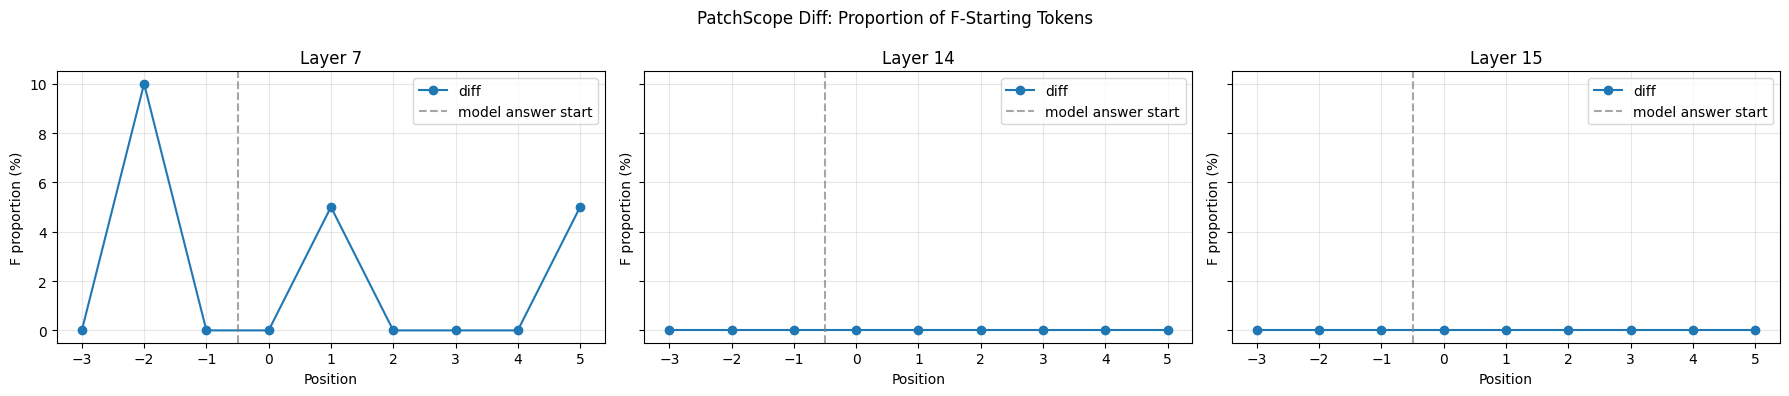

In [9]:
# Compute F proportion for PatchScope diff tokens across positions
ps_plot_data = {layer: {"positions": [], "diff_pct": []} for layer in LAYERS}

for pos in range(-3, 6):
    for layer in LAYERS:
        ps_positions = discover_patchscope_positions(layer)
        if pos not in ps_positions and pos >= 0:
            # Try loading anyway; use 0 if not available
            try:
                df = patchscope_position_table_single(layer, pos)
            except FileNotFoundError:
                ps_plot_data[layer]["positions"].append(pos)
                ps_plot_data[layer]["diff_pct"].append(0.0)
                continue
        else:
            try:
                df = patchscope_position_table_single(layer, pos)
            except FileNotFoundError:
                ps_plot_data[layer]["positions"].append(pos)
                ps_plot_data[layer]["diff_pct"].append(0.0)
                continue

        diff_col = df["diff"].dropna()
        total = len(diff_col[diff_col != ""])
        f_count = 0
        for entry in diff_col:
            if not entry:
                continue
            token = entry.split(" (")[0].strip()
            first = get_first_letter(token)
            if first and first == "f":
                f_count += 1
        pct = f_count / total * 100 if total > 0 else 0.0
        ps_plot_data[layer]["positions"].append(pos)
        ps_plot_data[layer]["diff_pct"].append(pct)
        print(f"Layer {layer}, pos {pos}: {f_count}/{total} = {pct:.1f}%")

# Plot
fig, axes = plt.subplots(1, len(LAYERS), figsize=(6 * len(LAYERS), 4), sharey=True)
if len(LAYERS) == 1:
    axes = [axes]

for ax, layer in zip(axes, LAYERS):
    ax.plot(
        ps_plot_data[layer]["positions"],
        ps_plot_data[layer]["diff_pct"],
        marker="o",
        label="diff",
        color="tab:blue",
    )
    ax.axvline(
        x=-0.5, color="gray", linestyle="--", alpha=0.7, label="model answer start"
    )
    ax.set_title(f"Layer {layer}")
    ax.set_xlabel("Position")
    ax.set_ylabel("F proportion (%)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle("PatchScope Diff: Proportion of F-Starting Tokens")
plt.tight_layout()
plt.show()

### 2B. Aggregated Across All PatchScope Positions

Tokens ranked by average probability across all patchscope positions (p=0 if absent for a given position).  
Green checkmark if the token was in `selected_tokens` for **any** position.  
Format: `token (avg_prob)`

In [10]:
def patchscope_aggregated_single(layer):
    ps_positions = discover_patchscope_positions(layer)
    n_ps = len(ps_positions)

    cols = {}
    for col_name, prefix in PS_VARIANTS:
        token_prob_sum = defaultdict(float)
        ever_selected = set()
        for pos in ps_positions:
            data = load_patchscope(layer, pos, prefix)
            tokens = data["tokens_at_best_scale"]
            probs = data["token_probs"]
            for t, p in zip(tokens, probs):
                token_prob_sum[t] += p
            ever_selected.update(_normalize_token(t) for t in data["selected_tokens"])

        token_avg = {t: s / n_ps for t, s in token_prob_sum.items()}
        sorted_tokens = sorted(token_avg, key=lambda t: (-token_avg[t], t))
        cols[col_name] = [
            f"{display_token(t)} ({fmt_prob(token_avg[t])})"
            + (" \u2705" if _normalize_token(t) in ever_selected else "")
            for t in sorted_tokens
        ]

    max_len = max(len(v) for v in cols.values())
    for k in cols:
        cols[k] += [""] * (max_len - len(cols[k]))
    return pd.DataFrame(cols)


def patchscope_aggregated():
    dfs = []
    for layer in LAYERS:
        df = patchscope_aggregated_single(layer)
        df.columns = pd.MultiIndex.from_product([[f"layer_{layer}"], df.columns])
        dfs.append(df)
    return concat_layer_dfs(dfs)


ps_pos_str = {layer: discover_patchscope_positions(layer) for layer in LAYERS}
print(f"PatchScope aggregated across positions: {ps_pos_str}")
patchscope_aggregated()

PatchScope aggregated across positions: {7: [0, 1, 2, 3, 4, 5], 14: [0, 1, 2, 3, 4, 5], 15: [0, 1, 2, 3, 4, 5]}


layer_7                             \
                         base                         ft   
0         /problem (0.0328) ✅           solve (0.0415) ✅   
1                 's (0.0295)                's (0.0294)   
2        /problems (0.0209) ✅        /problem (0.0289) ✅   
3            solve (0.0184) ✅               the (0.0232)   
4        /entities (0.0184) ✅       /entities (0.0197) ✅   
5          /manage (0.0130) ✅       /problems (0.0187) ✅   
6                the (0.0127)               you (0.0141)   
7                you (0.0107)         /manage (0.0133) ✅   
8           .Today (5.27e-03)          .Today (5.17e-03)   
9     understand (4.95e-03) ✅       /global (4.63e-03) ✅   
10           seems (4.90e-03)               , (4.02e-03)   
11       /global (4.46e-03) ✅            your (3.96e-03)   
12               , (4.34e-03)  /preferences (3.94e-03) ✅   
13  /preferences (3.98e-03) ✅     /provider (3.43e-03) ✅   
14        solves (3.97e-03) ✅    understand (3.06e-03) ✅   
15       address (3.77e-03) ✅        solves (2.97e-03) ✅   
16            your (3.34e-03)       /layout (2.71e-03) ✅   
17       /crypto (3.13e-03) ✅            this (2.57e-03)   
18              ’s (3.13e-03)          /job (2.56e-03) ✅   
19     /provider (3.05e-03) ✅   /connection (2.53e-03) ✅   
20       /object (2.33e-03) ✅       address (2.32e-03) ✅   
21           :\n\n (2.32e-03)           seems (2.27e-03)   
22          /job (2.27e-03) ✅      /logging (2.16e-03) ✅   
23   /connection (2.26e-03) ✅       /object (1.96e-03) ✅   
24  /application (1.71e-03) ✅       /crypto (1.91e-03) ✅   
25       analyze (1.70e-03) ✅              we (1.89e-03)   
26       /shared (1.64e-03) ✅      /effects (1.73e-03) ✅   
27       /layout (1.62e-03) ✅              ’s (1.56e-03)   
28      /effects (1.58e-03) ✅       /shared (1.52e-03) ✅   
29        tackle (1.55e-03) ✅           /pr (1.33e-03) ✅   
30             /pr (1.53e-03)      /respond (1.27e-03) ✅   
31     /activity (1.52e-03) ✅       /engine (1.22e-03) ✅   
32              we (1.39e-03)     /activity (1.04e-03) ✅   
33            /man (1.35e-03)  /controllers (1.04e-03) ✅   
34       /engine (1.35e-03) ✅           :\n\n (1.03e-03)   
35         break (1.29e-03) ✅       analyze (1.03e-03) ✅   
36        answer (1.17e-03) ✅      /company (9.97e-04) ✅   
37            /con (1.12e-03)        /tasks (9.92e-04) ✅   
38  /environment (1.09e-03) ✅        tackle (9.61e-04) ✅   
39  /controllers (1.08e-03) ✅          .Round (9.32e-04)   
40        /legal (1.06e-03) ✅              is (9.10e-04)   
41          begins (9.93e-04)          begins (8.07e-04)   
42        /tasks (9.33e-04) ✅      /testing (7.02e-04) ✅   
43             /pl (9.10e-04)            /con (6.39e-04)   
44               : (8.99e-04)          /reg (6.26e-04) ✅   
45        solved (8.09e-04) ✅      WHATSOEVER (5.98e-04)   
46      /logging (6.55e-04) ✅        solved (5.56e-04) ✅   
47      /testing (6.28e-04) ✅  /application (5.52e-04) ✅   
48          /reg (5.98e-04) ✅     /customer (5.52e-04) ✅   
49      /respond (5.48e-04) ✅           /pl (5.48e-04) ✅   
50      WHATSOEVER (5.01e-04)       /dialog (5.35e-04) ✅   
51       /dialog (4.88e-04) ✅  /environment (5.04e-04) ✅   
52       /entity (4.87e-04) ✅      /general (5.04e-04) ✅   
53          .Round (4.84e-04)        answer (5.01e-04) ✅   
54     /customer (4.62e-04) ✅         /spec (4.96e-04) ✅   
55         /spec (4.26e-04) ✅        /legal (4.93e-04) ✅   
56                                /resource (4.93e-04) ✅   
57                                  /entity (4.87e-04) ✅   
58                                       /man (4.87e-04)   
59                                 /vendors (4.73e-04) ✅   
60                                     /use (4.06e-04) ✅   
61                                                         
62                                                         
63                                                         
64                                                         
65

## 3. Diff Logit Lens Across Positions

Shows only the **diff** variant of the logit lens for selected positions across all layers.
Format: `token (softmax_prob)`

In [26]:
DIFF_POSITIONS = [-3, -1, 0, 1, 2, 3, 10, 50, 100]


def logit_lens_diff_positions_table():
    """Show diff logit lens across multiple positions for all layers."""
    dfs = []
    for layer in LAYERS:
        col_data = {}
        for pos in DIFF_POSITIONS:
            prefix, pi, ii = LL_VARIANTS["diff"]
            data = load_logit_lens(layer, pos, prefix)
            tokens = decode_tokens(data[ii])
            probs = data[pi].tolist()
            col = [f"{display_token(t)} ({fmt_prob(p)})" for t, p in zip(tokens, probs)]
            if LOGIT_LENS_MAX_ROWS is not None:
                col = col[:LOGIT_LENS_MAX_ROWS]
            col_data[f"pos_{pos}"] = col
        layer_df = pd.DataFrame(col_data)
        layer_df.columns = pd.MultiIndex.from_product(
            [[f"layer_{layer}"], layer_df.columns]
        )
        dfs.append(layer_df)
    return concat_layer_dfs(dfs)


print(f"Logit lens DIFF across positions: {DIFF_POSITIONS}")
logit_lens_diff_positions_table()

Logit lens DIFF across positions: [-3, -1, 0, 1, 2, 3, 10, 50, 100]


layer_7                                                \
                    pos_-3                 pos_-1                  pos_0   
0        plusplus (0.0106)           aph (0.0171)           oyo (0.0151)   
1          EMPL (7.32e-03)       ından (9.16e-03)   longevity (4.30e-03)   
2           ash (6.26e-03)        Seam (5.22e-03)      repair (3.16e-03)   
3         opard (6.07e-03)         oyo (4.61e-03)      ulares (2.96e-03)   
4          ploy (3.57e-03)       lived (3.27e-03)       sweat (2.79e-03)   
5           ++. (3.34e-03)       quivo (3.17e-03)       ropri (2.46e-03)   
6      Trafford (3.14e-03)        Lore (3.17e-03)         ять (2.30e-03)   
7          ieee (2.53e-03)    Seamless (2.98e-03)      Appeal (2.17e-03)   
8    literature (2.53e-03)       ashes (2.47e-03)        ajes (2.17e-03)   
9         spawn (2.38e-03)        Thom (2.40e-03)         ona (2.04e-03)   
10    empowered (2.38e-03)    HostName (2.40e-03)       Combo (2.04e-03)   
11          bos (2.30e-03)        weep (2.32e-03)        shed (1.91e-03)   
12   pendicular (2.17e-03)   Gathering (2.24e-03)    destruct (1.91e-03)   
13     /helpers (2.09e-03)         Unc (2.18e-03)       abajo (1.80e-03)   
14    Transpose (2.03e-03)     raising (2.04e-03)      lombok (1.80e-03)   
15   Literature (1.97e-03)       asher (1.86e-03)      igkeit (1.74e-03)   
16       ouched (1.97e-03)         nor (1.81e-03)      unidad (1.69e-03)   
17     IGHLIGHT (1.91e-03)   longevity (1.81e-03)         Kle (1.64e-03)   
18          usa (1.85e-03)        Levi (1.75e-03)       Split (1.59e-03)   
19        ACTER (1.79e-03)        live (1.75e-03)        airo (1.59e-03)   

                                                                           \
                  pos_1                    pos_2                    pos_3   
0         unda (0.0148)          ügen (5.95e-03)      IGHLIGHT (6.65e-03)   
1        oyo (6.16e-03)          desc (4.91e-03)          desc (5.86e-03)   
2       onet (5.43e-03)          agus (4.64e-03)          unda (5.49e-03)   
3      auses (4.52e-03)           sof (4.09e-03)          agus (5.19e-03)   
4       ajes (3.74e-03)           ông (3.83e-03)          ügen (5.19e-03)   
5    bitwise (3.74e-03)   ...\n\n\n\n (3.83e-03)   ...\n\n\n\n (5.19e-03)   
6      forme (3.51e-03)      IGHLIGHT (3.60e-03)      licensee (2.94e-03)   
7        Geg (3.10e-03)          unda (3.39e-03)       Desmond (2.76e-03)   
8       -net (2.73e-03)          MENU (3.39e-03)         posts (2.59e-03)   
9     Morrow (2.56e-03)       confort (2.99e-03)           ông (2.59e-03)   
10        §§ (2.41e-03)       bitwise (2.81e-03)            de (2.15e-03)   
11       mec (2.27e-03)         auses (2.81e-03)          Born (2.03e-03)   
12       uil (2.27e-03)       Desmond (2.47e-03)          goto (1.90e-03)   
13        zy (2.14e-03)     .splitext (2.32e-03)        -suite (1.90e-03)   
14      goto (2.00e-03)          goto (2.18e-03)           bst (1.79e-03)   
15      kort (1.88e-03)      licensee (2.18e-03)          shed (1.79e-03)   
16       diy (1.88e-03)       LIMITED (2.04e-03)    exhausting (1.68e-03)   
17      aldi (1.76e-03)           amu (1.93e-03)        Expand (1.68e-03)   
18    partie (1.76e-03)         Merge (1.81e-03)          MENU (1.68e-03)   
19      anky (1.76e-03)           zig (1.81e-03)       ometown (1.68e-03)   

                                                       \
                     pos_10                    pos_50   
0             unda (0.0124)          sheds (5.22e-03)   
1          sheds (7.51e-03)          posts (5.04e-03)   
2          posts (5.16e-03)        project (4.88e-03)   
3           shed (4.55e-03)           shed (3.69e-03)   
4           Born (4.27e-03)     laboratory (3.46e-03)   
5    ...\n\n\n\n (3.66e-03)           maid (3.07e-03)   
6          posts (3.34e-03)            spo (2.87e-03)   
7           maid (2.94e-03)          clone (2.53e-03)   
8      worldwide (2.85e-03)        physics (2.53e-03)   
9      Worldwide (2.85e-

## 4. Diff PatchScope Across Positions

Shows only the **diff** variant of PatchScope for selected positions across all layers.
Format: `token (prob)` with `✅` if in `selected_tokens`

In [28]:
PS_DIFF_POSITIONS = [-3, -1, 0, 1, 2, 3]


def patchscope_diff_positions_table():
    """Show diff patchscope across multiple positions for all layers."""
    dfs = []
    for layer in LAYERS:
        col_data = {}
        for pos in PS_DIFF_POSITIONS:
            try:
                data = load_patchscope(layer, pos, prefix="")
            except FileNotFoundError:
                col_data[f"pos_{pos}"] = ["(not available)"]
                continue
            tokens = data["tokens_at_best_scale"]
            selected = {_normalize_token(t) for t in data["selected_tokens"]}
            probs = data["token_probs"]
            col = [
                f"{display_token(t)} ({fmt_prob(p)})"
                + (" ✅" if _normalize_token(t) in selected else "")
                for t, p in zip(tokens, probs)
            ]
            col_data[f"pos_{pos}"] = col
        layer_df = pd.DataFrame({k: pd.Series(v) for k, v in col_data.items()}).fillna(
            ""
        )
        layer_df.columns = pd.MultiIndex.from_product(
            [[f"layer_{layer}"], layer_df.columns]
        )
        dfs.append(layer_df)
    return concat_layer_dfs(dfs)


print(f"PatchScope DIFF across positions: {DIFF_POSITIONS}")
patchscope_diff_positions_table()

PatchScope DIFF across positions: [-3, -1, 0, 1, 2, 3, 10, 50, 100]


layer_7                                                  \
                      pos_-3                   pos_-1                  pos_0   
0      plusplus (9.87e-03) ✅             ' ' (0.1589)        Text (0.0592) ✅   
1           opard (6.77e-03)           man (0.0204) ✅           arm (0.0210)   
2            EMPL (6.50e-03)               I (0.0178)        text (0.0197) ✅   
3             ash (6.24e-03)          Anna (0.0145) ✅           ' ' (0.0189)   
4            ploy (3.98e-03)               [ (0.0139)       Level (0.0134) ✅   
5        Trafford (3.98e-03)              -> (0.0110)     '       ' (0.0106)   
6             ++. (3.01e-03)        bear (8.55e-03) ✅          '  ' (0.0104)   
7    literature (2.60e-03) ✅           Man (8.03e-03)      '    ' (8.76e-03)   
8       empowered (2.49e-03)        blue (5.83e-03) ✅      Team (8.52e-03) ✅   
9           spawn (2.44e-03)        Emma (4.31e-03) ✅       '   ' (6.31e-03)   
10         ouched (2.41e-03)           you (4.22e-03)      Grid (4.77e-03) ✅   
11         ieee (2.32e-03) ✅           Pro (3.72e-03)     Party (4.10e-03) ✅   
12     pendicular (2.25e-03)   character (3.31e-03) ✅          re (3.81e-03)   
13            bos (2.18e-03)        John (2.99e-03) ✅           X (3.63e-03)   
14            usa (2.15e-03)         Inter (2.86e-03)        look (3.52e-03)   
15       IGHLIGHT (2.07e-03)        '  \n' (2.83e-03)         nel (3.43e-03)   
16         .gen (2.00e-03) ✅           Exc (2.71e-03)          aa (3.41e-03)   
17     /helpers (1.79e-03) ✅          Cent (2.62e-03)          lo (3.40e-03)   
18   Literature (1.77e-03) ✅     Character (2.33e-03)      Text (3.28e-03) ✅   
19    Transpose (1.73e-03) ✅             M (2.20e-03)   Article (3.19e-03) ✅   

                                                         \
                          pos_1                   pos_2   
0                 unda (0.0211)      letters (0.0203) ✅   
1                 no (5.67e-03)       letter (0.0134) ✅   
2                kes (3.99e-03)   articles (6.29e-03) ✅   
3        traumatic (3.62e-03) ✅     column (5.21e-03) ✅   
4                eld (3.55e-03)           no (4.99e-03)   
5              Fleet (3.44e-03)     titled (4.14e-03) ✅   
6           tragic (3.27e-03) ✅            T (4.09e-03)   
7          Sheldon (3.01e-03) ✅          hoa (3.96e-03)   
8             head (2.82e-03) ✅            o (3.94e-03)   
9               Sang (2.79e-03)          000 (3.52e-03)   
10               mec (2.65e-03)      Letters (3.46e-03)   
11         Desmond (2.62e-03) ✅     author (3.29e-03) ✅   
12          search (2.46e-03) ✅          ' ' (2.88e-03)   
13          titled (2.46e-03) ✅           No (2.84e-03)   
14               lor (2.44e-03)            ج (2.59e-03)   
15              asca (2.39e-03)           hy (2.59e-03)   
16          column (2.29e-03) ✅        hasil (2.45e-03)   
17              Wass (2.25e-03)           's (2.33e-03)   
18   heartbreaking (2.24e-03) ✅          RNA (2.30e-03)   
19               pto (2.20e-03)         some (2.29e-03)   

                                         layer_14                            \
                     pos_3                 pos_-3                    pos_-1   
0              bo (0.0123)        AI (5.19e-03) ✅            paque (0.0358)   
1            hy (7.79e-03)        enti (5.16e-03)             että (0.0106)   
2           000 (7.62e-03)           * (3.15e-03)        attered (7.03e-03)   
3      column (6.80e-03) ✅     Robot (2.94e-03) ✅          besar (6.85e-03)   
4     century (6.18e-03) ✅        STUD (2.75e-03)    apologize (5.76e-03) ✅   
5     website (5.23e-03) ✅       Duffy (2.66e-03)             že (5.62e-03)   
6             o (4.94e-03)          \$ (2.47e-03)            .cz (5.50e-03)   
7            we (4.84e-03)           率 (2.46e-03)         semble (4.08e-03)   
8      Eugene (4.71e-03) ✅          ом (2.41e-03)       alculate (3.45e-03)   
9          that (4.41e-03)          PU (2.31e-03)          elles (3.40e-03)   
10      alcoh